# Project 1: Introduction to machine learning - Regression



Author: Jakob Nyström

Date: 2021-02-18


### Introduction

In this project we will use three types of machine learning algorithms for regression to predict house prices for Boston suburbs: linear regression, K nearest neighbors and a neural network. The dataset is the so called Boston housing dataset collected in 1970. Target variable is the median house price in each suburb, and there are 13 explantory variables that capture different features of each suburb.

In [93]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import VisualizeNN as VisNN
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.exceptions import ConvergenceWarning

## Part 1: Data preparation and inspection

### 1a) Load data and investigate shape

We load the dataset from the sklearn library and create a dataframe. Column names are replaced with more descriptive ones that will be easier to work with.

The dataset has dimensions (506, 14) i.e. 506 rows that each represent one suburb for which there is data, and 14 columns representing the 13 explanatory variables and the target variable.

In [21]:
# Load built-in dataset

from sklearn.datasets import load_boston
housing_data = load_boston(return_X_y=False)
X = housing_data.data
y = housing_data.target
col_names = housing_data.feature_names


# Create dataframe with X, y and feature names

housing_df = pd.DataFrame(data=X, columns=col_names)
housing_df['median_house_val'] = y


# More descriptive feature names

new_col_names = ['crime_per_cap', 
                 'zoned_land_share', 
                 'ind_land_share', 
                 'charles_river', 
                 'nitric_oxides', 
                 'avg_no_rooms', 
                 'pre_1940_units_share', 
                 'employ_centre_dist', 
                 'highway_access', 
                 'tax_rate', 
                 'pupil_teacher_ratio', 
                 'blacks_share', 
                 'low_status_share']

old_col_list = col_names.tolist()
new_cols = {old_col_list[i]: new_col_names[i] for i in range(len(old_col_list))}
housing_df.rename(columns=new_cols, inplace=True)
housing_df.head(5)

,crime_per_cap,zoned_land_share,ind_land_share,charles_river,nitric_oxides,avg_no_rooms,pre_1940_units_share,employ_centre_dist,highway_access,tax_rate,pupil_teacher_ratio,blacks_share,low_status_share,median_house_val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [22]:
# Get dimension for the data set

housing_df.shape

(506, 14)

### 1b) Visualizing relationships in the data

We create a correlation matrix for all variables in the dataset and plot this on a heatmap to visualize it, see Figure 1. Green to blue shades represent positive correlations (where darker is higher) and yellow to red means negative correlations.

Looking at the last row with correlations between the target variable and the other variables we see that correlations are relatively high (in absolute terms) in general. E.g. crime rate seems to have a strong negative correlation with house prices, which is not surprising. Conversely, higher number of rooms is correlated with higher prices since that indicates the size of the average house in the area.

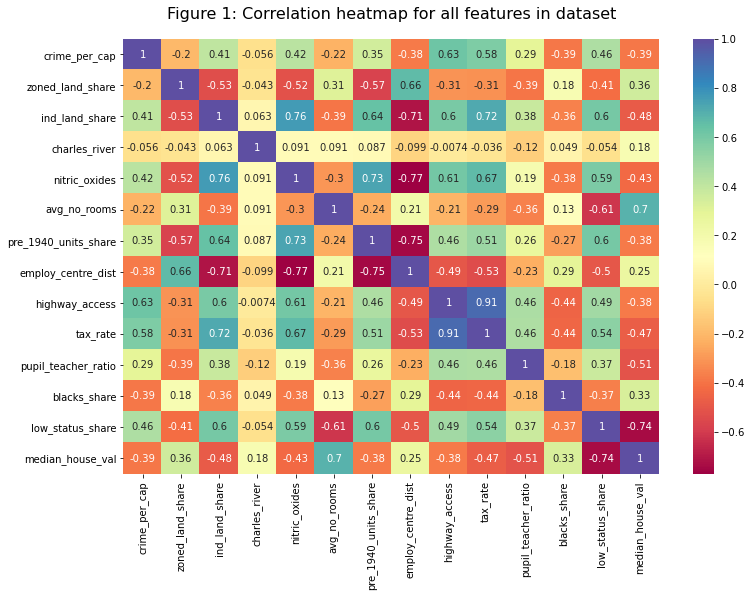

In [23]:
# Plot correlation values in heatmap

housing_corr = housing_df.corr()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(housing_corr, annot=True, cmap='Spectral')
plt.title('Figure 1: Correlation heatmap for all features in dataset', fontsize=16, pad=20)

print()
plt.show()

We will continue by plotting all explanatory variables against the target variable in pair-wise scatter plots, see Figure 2. These relationships are visualized below. Note that one variable (share of black population) has been left out to fit plots in the 3x4 grid. (As a tangent, one should probably also have an "ethics in AI" discussion before such a feature is used in any real, applied setting.)

It seems that the following features have the most clear relationship with median house value:
- Crime rate, nitric oxides, average number of rooms, pupil-teacher ratio and share of "low status" population 

Also the following variables could potentially add some explanatory power to the model, although relationships seem relatively weak:
- Industrial land share, share of pre-1940 built homes, distance to employment centers, tax rate, and zoned land share
    
Features like the Charles river dummy and highway access seem to have limited bearing on the house values from a visual inspection. There also seems to be some potential from feature engineering / transformation, e.g. employ_centre_dist has a vaguely log shape and low_status_share is negatively exponential.

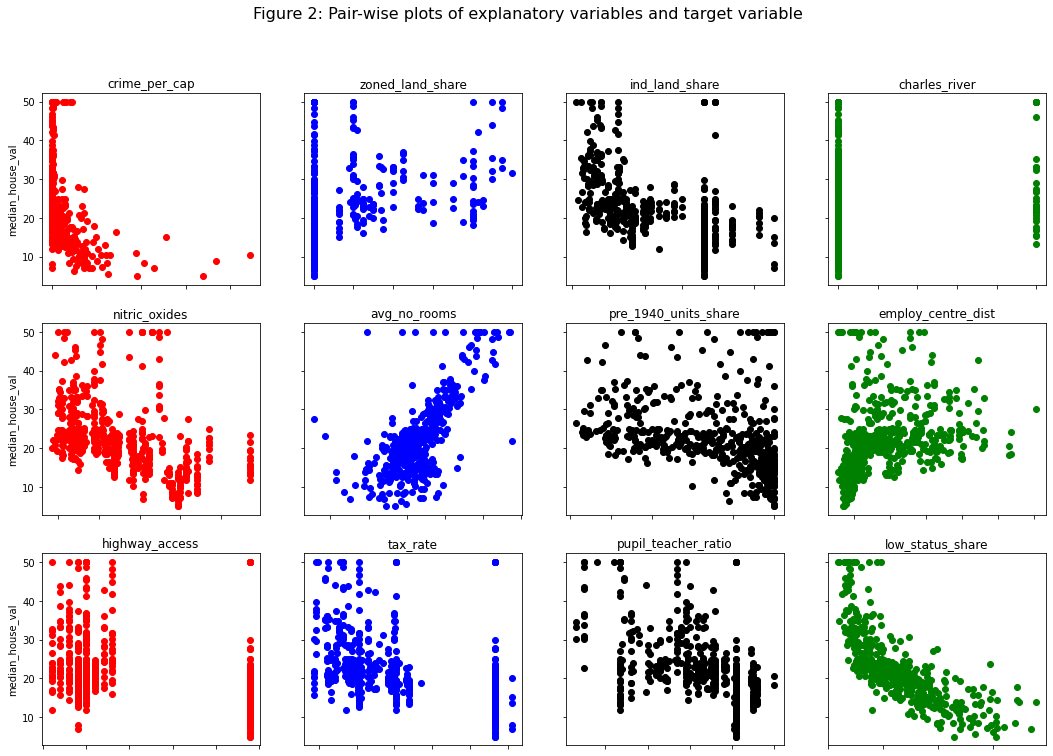

In [47]:
# Plot median_house_val against all explanatory variables

fig, axs = plt.subplots(3, 4, figsize=(18, 12))

axs[0, 0].scatter(housing_df[new_col_names[0]], housing_df['median_house_val'], c='red') 
axs[0, 0].set_title(new_col_names[0])
axs[0, 1].scatter(housing_df[new_col_names[1]], housing_df['median_house_val'], c='blue')
axs[0, 1].set_title(new_col_names[1])
axs[0, 2].scatter(housing_df[new_col_names[2]], housing_df['median_house_val'], c='black')
axs[0, 2].set_title(new_col_names[2])
axs[0, 3].scatter(housing_df[new_col_names[3]], housing_df['median_house_val'], c='green')
axs[0, 3].set_title(new_col_names[3])
axs[1, 0].scatter(housing_df[new_col_names[4]], housing_df['median_house_val'], c='red')
axs[1, 0].set_title(new_col_names[4])
axs[1, 1].scatter(housing_df[new_col_names[5]], housing_df['median_house_val'], c='blue')
axs[1, 1].set_title(new_col_names[5])
axs[1, 2].scatter(housing_df[new_col_names[6]], housing_df['median_house_val'], c='black')
axs[1, 2].set_title(new_col_names[6])
axs[1, 3].scatter(housing_df[new_col_names[7]], housing_df['median_house_val'], c='green')
axs[1, 3].set_title(new_col_names[7])
axs[2, 0].scatter(housing_df[new_col_names[8]], housing_df['median_house_val'], c='red')
axs[2, 0].set_title(new_col_names[8])
axs[2, 1].scatter(housing_df[new_col_names[9]], housing_df['median_house_val'], c='blue')
axs[2, 1].set_title(new_col_names[9])
axs[2, 2].scatter(housing_df[new_col_names[10]], housing_df['median_house_val'], c='black')
axs[2, 2].set_title(new_col_names[10])
axs[2, 3].scatter(housing_df[new_col_names[12]], housing_df['median_house_val'], c='green')
axs[2, 3].set_title(new_col_names[12])

for ax in axs.flat:
    ax.set(ylabel='median_house_val')

for ax in axs.flat: 
    ax.label_outer()
    
for ax in axs.flat:
    ax.set_xticklabels([])
    
fig.suptitle('Figure 2: Pair-wise plots of explanatory variables and target variable', fontsize=16)

print()
plt.show()

One thing that was discovered when training and testing is that there were large swings in MSE for the same model but different training and test sets. When plotting the dstribution of the target variable, in Figure 3, we can see that it approximately follows a normal distribution although with a skew towards lower values. However, note the large number of observations at 50. It seems the median house value is capped at 50, so one hypothesis could be that there are in fact observed median values above 50, but these have been coerced to a value of 50 (for some unknown reason). 

It should be noted that this could make it more difficult for the models to understand the relationship between house values and other variables. However, after using both the complete data set and a pruned version with these observations completely removed before the train-test split, test performance with the linear regression seems to be roughly on par, so I chose to leave them in (in each case generating 30 train-test splits and doing predictions for robustness).

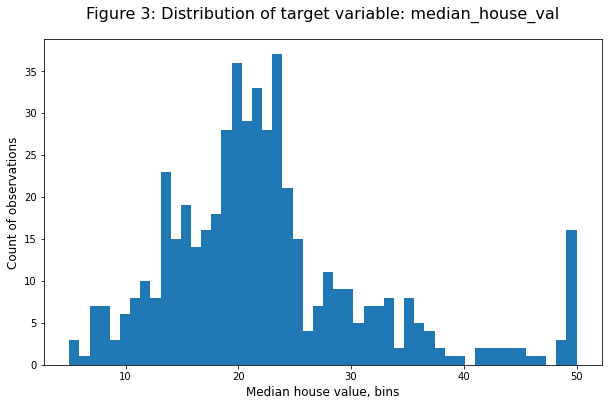

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.hist(housing_df['median_house_val'], bins=50)
plt.title('Figure 3: Distribution of target variable: median_house_val', fontsize=16, pad=20)
plt.ylabel('Count of observations', fontsize=12)
plt.xlabel('Median house value, bins', fontsize=12)

print()
plt.show()

### 1c) Split data into training and test sets

To finish of the data preparation, we split the dataset into a training set and a test set (25% of observations in the test set).

In [60]:
X = housing_df.drop(['median_house_val'], axis='columns')
Y = housing_df['median_house_val']

# NOT USED: Identify indices of house value outliers and remove from y_train and x_train

#Y_outliers = Y[Y == 50]
#outlier_index = Y_outliers.index.tolist()
#X.drop(outlier_index, inplace=True)
#Y.drop(outlier_index, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

## Part 2: Linear regression

### 2a) Introduction to linear regression

Linear regression attempts to explain the target variable using a linear combiation of the explanatory variables, on the form
y = m + kx where m is the intercept or bias variable and k is the coefficient for variable x. In the case of more than one x, each variable x1, x2, ..., xn will have a corresponding k, and the value of y is the weighted sum of all kx.

When the model is fitted to the training data, the algorithm tries to minimize the sum of squares, which is the squared distance between each actual observation y and the model's prediction y'.


### 2b) Linear regression with all variables

Below we fit a model that includes all the features in the dataset and make a prediction on the test set.

In [61]:
# Fitting model and making predictions on test and training set

linear_regression = LinearRegression(normalize=True).fit(x_train, y_train)

y_pred = linear_regression.predict(x_test)
y_pred_train = linear_regression.predict(x_train)

### 2c-d) Evaluating the results

Below we print the MSE on the test data, but also some other accuracy metrics to get a more holistic understanding of how the model is performing, see Table 1. Due to the "50 outliers" the MSE varies quite a bit between training-test runs, somewhere in the range of ~20-30 - this metric is sensitive to a few large deviations / outliers. It's promising to see that bias is small - on average deviations are relatively small, and there seems to be no systematic over- or under-prediction. MAPE is also decent at ~18%.

In [62]:
# Evaluating the model performance

model_fit = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred, squared=True), 3)
bias = round(sum(y_pred) / sum(y_test) - 1, 3)
mape = round(np.mean(np.abs((y_test - y_pred) / y_test)), 3)

print()
print('Table 1: Performance metrics of linear regression model')
print()
print('MSE:', mse)
print('R^2:', model_fit)
print('Bias:', bias)
print('MAPE', mape)


Table 1: Performance metrics of linear regression model

MSE: 21.65
R^2: 0.704
Bias: -0.016
MAPE 0.16


Below we have a plot of predicted and actual house values based on the model above (Figure 4). If the model was completely right in every case, all dots would follow the black line. Dots under the line are over-predictions, where the model predicts a higher value than what is actually observed - and vice versa for dots above the line.

In general the predictions are centered around the line, but there are a few outliers both for high and low predictions. Where the model is really off, it's generally underpredicting the value (both for high and low housing values).

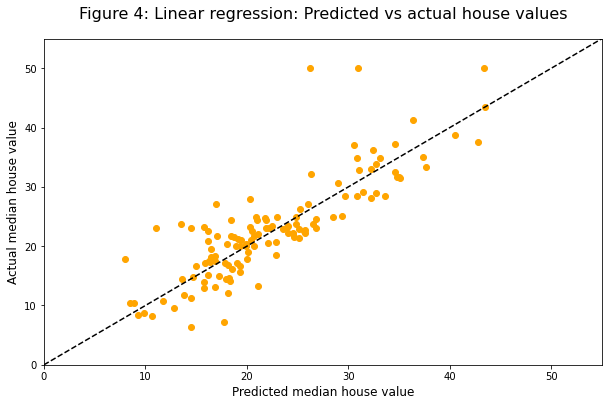

In [63]:
# Plot predicted vs actual values

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(y_pred, y_test, color='orange')
plt.xlabel('Predicted median house value', fontsize=12)
plt.ylabel('Actual median house value', fontsize=12)
plt.plot([0, 55], [0, 55], ls='--', color='black')
plt.title('Figure 4: Linear regression: Predicted vs actual house values', fontsize=16, pad=20)
plt.xlim(0, 55)
plt.ylim(0, 55)

print()
plt.show()

### 2e) Model with less features + feature transformation

Now we will investigate if the model can be improved (i.e. better test accuracy) by using fewer features, and by transforming some features that had a non-linear shape.

One idea is to use the features that were identified as most promising from the visual inspection in part 1. It should be noted that all of them are not fully independent from each other (e.g. high crime rate is intuitively positively correlated with the low status population share) but it still makes sense to include all since they also complement each other. We call this the "small model" below, and it contains these features:

- Crime rate, nitric oxides, average number of rooms, pupil-teacher ratio and share of "low status" population

As a second alternative model, I will also include some of the other features that were noted to potentially add explanatory power to the model. We call this the "medium model" and it contains all original features except:

- Share of black population, highway access proxy, and the Charles river dummy variable 

In terms of feature transformations, we take the log of these features (results shown in Figure 5):

- Crime rate, distance to employee centre, low status share and industrial land share

After the transformation, the relationships with the target variable are at least approximately linear, which can be seen in Figure 5. We replace the original four features with these, in the "transformed model".

Since the dataset is small and we saw above that the test metrics (especially MSE) can be sensitive to what observations end up in the training and test sets, we will create a loop that does the train-test split, trains and tests each model 30 times and compare the average metrics to see if one model is better than the others. 

In [43]:
housing_df['crime_per_cap_2'] = np.log(housing_df['crime_per_cap'])
housing_df['employ_centre_dist_2'] = np.log(housing_df['employ_centre_dist'])
housing_df['low_status_share_2'] = np.log(housing_df['low_status_share'])
housing_df['ind_land_share_2'] = np.log(housing_df['ind_land_share'])

X = housing_df.drop(['median_house_val'], axis='columns')
Y = housing_df['median_house_val']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
housing_df

,crime_per_cap,zoned_land_share,ind_land_share,charles_river,nitric_oxides,avg_no_rooms,pre_1940_units_share,employ_centre_dist,highway_access,tax_rate,pupil_teacher_ratio,blacks_share,low_status_share,median_house_val,crime_per_cap_2,employ_centre_dist_2,low_status_share_2,ind_land_share_2
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,-5.064036,1.408545,1.605430,0.837248
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,-3.600502,1.602836,2.212660,1.955860
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,-3.601235,1.602836,1.393766,1.955860
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,-3.430523,1.802073,1.078410,0.779325
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,-2.672924,1.802073,1.673351,0.779325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4,-2.770511,0.907694,2.269028,2.479056
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6,-3.095111,0.827460,2.206074,2.479056
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9,-2.800824,0.773574,1.729884,2.479056
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0,-2.211009,0.870833,1.868721,2.479056


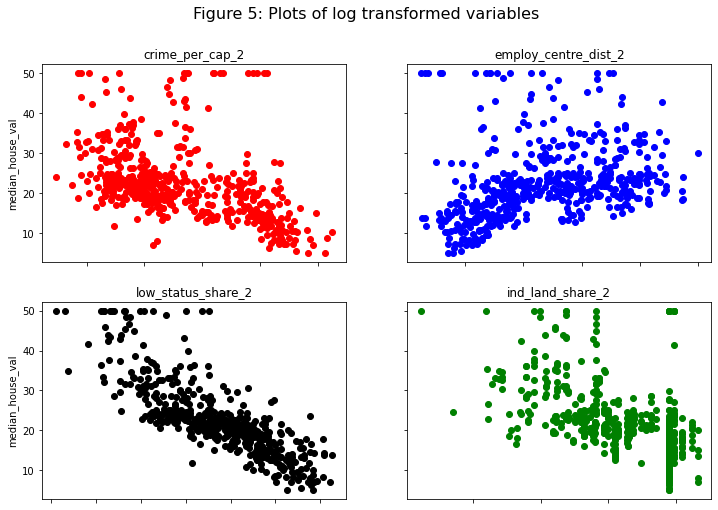

In [48]:
# Plot the transformed variables against median_house_value

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].scatter(housing_df['crime_per_cap_2'], housing_df['median_house_val'], c='red') 
axs[0, 0].set_title('crime_per_cap_2')
axs[0, 1].scatter(housing_df['employ_centre_dist_2'], housing_df['median_house_val'], c='blue')
axs[0, 1].set_title('employ_centre_dist_2')
axs[1, 0].scatter(housing_df['low_status_share_2'], housing_df['median_house_val'], c='black')
axs[1, 0].set_title('low_status_share_2')
axs[1, 1].scatter(housing_df['ind_land_share_2'], housing_df['median_house_val'], c='green')
axs[1, 1].set_title('ind_land_share_2')

for ax in axs.flat:
    ax.set(ylabel='median_house_val')

for ax in axs.flat:
    ax.label_outer()
    
for ax in axs.flat:
    ax.set_xticklabels([])
    
fig.suptitle('Figure 5: Plots of log transformed variables', fontsize=16)

print()
plt.show()

In [49]:
# Select the most inclusive feature sets

X = housing_df.drop(['median_house_val'], axis='columns')
Y = housing_df['median_house_val']

mse_large_model = []
mse_small_model = []
mse_medium_model = []
mse_transformed_model = []

# Train and test each model 30 times

for i in range(30):
    
    # Generate the basic training-test split
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
    
    # Drop features to get the more reduced sets
    
    x1_train = x_train.drop(['crime_per_cap_2', 'ind_land_share_2', 'employ_centre_dist_2', 'low_status_share_2'], axis=1)
    x1_test = x_test.drop(['crime_per_cap_2', 'ind_land_share_2', 'employ_centre_dist_2', 'low_status_share_2'], axis=1)
    
    x2_train = x_train[['crime_per_cap', 'nitric_oxides', 'avg_no_rooms', 'pupil_teacher_ratio', 'low_status_share']]
    x2_test = x_test[['crime_per_cap', 'nitric_oxides', 'avg_no_rooms', 'pupil_teacher_ratio', 'low_status_share']]

    x3_train = x1_train.drop(['blacks_share', 'highway_access', 'charles_river'], axis=1)
    x3_test = x1_test.drop(['blacks_share', 'highway_access', 'charles_river'], axis=1)
                          
    x4_train = x_train.drop(['crime_per_cap', 'ind_land_share', 'employ_centre_dist', 'low_status_share'], axis=1)
    x4_test = x_test.drop(['crime_per_cap', 'ind_land_share', 'employ_centre_dist', 'low_status_share'], axis=1)
    
    # Fit the 4 different models 
    large_model = LinearRegression(normalize=True).fit(x1_train, y_train)
    small_model = LinearRegression(normalize=True).fit(x2_train, y_train)
    medium_model = LinearRegression(normalize=True).fit(x3_train, y_train)
    transformed_model = LinearRegression(normalize=True).fit(x4_train, y_train)        
    
    # Make predictions using each model
    y1_pred = large_model.predict(x1_test)
    y2_pred = small_model.predict(x2_test)
    y3_pred = medium_model.predict(x3_test)
    y4_pred = transformed_model.predict(x4_test)
    
    mse_large_model.append(mean_squared_error(y_test, y1_pred, squared=True))
    mse_small_model.append(mean_squared_error(y_test, y2_pred, squared=True))
    mse_medium_model.append(mean_squared_error(y_test, y3_pred, squared=True))
    mse_transformed_model.append(mean_squared_error(y_test, y4_pred, squared=True))
                          
    mse_large_avg = round(sum(mse_large_model) / len(mse_large_model), 3)
    mse_small_avg = round(sum(mse_small_model) / len(mse_small_model), 3)
    mse_medium_avg = round(sum(mse_medium_model) / len(mse_medium_model), 3)
    mse_transformed_avg = round(sum(mse_transformed_model) / len(mse_transformed_model), 3)                      

print()
print('Table 2: MSE for different linear regression models')
print()
print('Large model avg MSE:', mse_large_avg)
print('Small model avg MSE:', mse_small_avg)
print('Medium model avg MSE:', mse_medium_avg)
print('Transformed model avg MSE:', mse_transformed_avg)


Table 2: MSE for different linear regression models

Large model avg MSE: 23.044
Small model avg MSE: 26.944
Medium model avg MSE: 24.767
Transformed model avg MSE: 17.969


Based on the results above in Table 2, it seems that a) the feature transformations did its job of significantly improving the model performance, and that generally having more features increases performance (looking at the difference between the small, medium and large model).


## Part 3: K nearest neighbors regression


### 3a) Introduction to K-nn

In a K nearest neighbor model, during training, the data set is partitioned into a number of clusters each containing k neighboring points that are similar in their feature values. A new observation for which we are trying to make a prediction, is assigned to the cluster that is most similar to it based on its feature values. This new observation is given a target variable value equal to the average of the neighbors in the assigned cluster. 

During training the model tries to select clusters of k neighbors so that the (Euclidian) distance between the neighbor points is as small as possible, while the distance to other clusters is as large as possible.


### 3b) Fitting a K-nn model with k = 10

We begin by fitting a model with k = 10 (the number of neighbors assigned to each cluster or group of neighbors. We use the same training and test data as for the original linear regression model. 

In [64]:
# Fitting model and making predictions on test and training set

knn_regression = KNeighborsRegressor(n_neighbors=10).fit(x_train, y_train)

y_pred = knn_regression.predict(x_test)
y_pred_train = knn_regression.predict(x_train)

In [65]:
# Evaluating the model performance

model_fit = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred, squared=True), 3)
bias = round(sum(y_pred) / sum(y_test) - 1, 3)
mape = round(np.mean(np.abs((y_test - y_pred) / y_test)), 3)

print()
print('Table 3: Performance metrics of K nearest neighbor model')
print()
print('MSE:', mse)
print('R^2:', model_fit)
print('Bias:', bias)
print('MAPE', mape)


Table 3: Performance metrics of K nearest neighbor model

MSE: 42.094
R^2: 0.424
Bias: 0.008
MAPE 0.222


The results are not so good for this choice of k (see Table 3). An MSE of ~42 and much more spread when we plot predicted against actual values (Figure 6), is considerably worse than the linear regression model which had an MSE of ~22 with this training and test set. It seems the model has an especially hard time predicting higher house values.

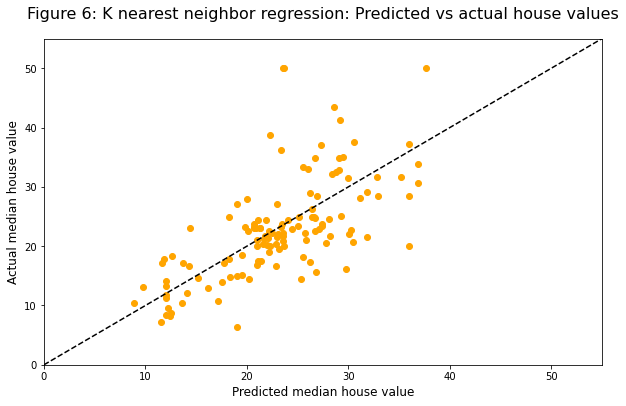

In [66]:
# Plot predicted vs actual values

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(y_pred, y_test, color='orange')
plt.xlabel('Predicted median house value', fontsize=12)
plt.ylabel('Actual median house value', fontsize=12)
plt.plot([0, 55], [0, 55], ls='--', color='black')
plt.title('Figure 6: K nearest neighbor regression: Predicted vs actual house values', fontsize=16, pad=20)
plt.xlim(0, 55)
plt.ylim(0, 55)

print()
plt.show()

### 3c-d) Testing different k and features; bias-variance tradeoff

Let's see if we can improve the model by changing the value of k and using the log transformed features above. We start by looping through different values of k = 1, 2, ...., 15. To increase robustness we create an outer loop that does 30 iterations of the inner k loop, similar to the linear regression example above.

In [67]:
mse_test_dict = {}
mse_train_dict = {}
min_k = 1
max_k = 15

# Loop over k=1, 2, ..., 15 and store the result of each k

for i in range(30):
    
    # Generate the basic training-test split
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
    
    # Loop over values of k, fit model and make prediction
    for k in range(min_k, max_k + 1):
        knn_regression = KNeighborsRegressor(n_neighbors=k).fit(x_train, y_train)

        y_pred = knn_regression.predict(x_test)
        y_pred_train = knn_regression.predict(x_train)
    
        # Calculate MSE and save in dictionaries
        mse_test = mean_squared_error(y_test, y_pred, squared=True)
        mse_train = mean_squared_error(y_train, y_pred_train, squared=True)
    
        if i == 0:
            mse_test_dict[k] = [mse_test]
            mse_train_dict[k] = [mse_train]
        else:
            mse_test_dict[k].append(mse_test)
            mse_train_dict[k].append(mse_train)

mse_test_avg = {}
mse_train_avg = {}

for k, value in mse_test_dict.items():
    mse_test_avg[k] = sum(value) / len(value)
    
for k, value in mse_train_dict.items():
    mse_train_avg[k] = sum(value) / len(value)

# Print out the results

print()
print('Table 4: Training and test MSE for different k')
print()
print('k' + '\t' + 'Train MSE' + '\t' + 'Test MSE')
print()
for k in range(min_k, max_k + 1):
    print(str(k) + '\t' + str(round(mse_train_avg[k], 3)) + '\t\t' + str(round(mse_test_avg[k], 3)))


Table 4: Training and test MSE for different k

k	Train MSE	Test MSE

1	0.0		53.477
2	12.983		43.938
3	19.08		41.599
4	22.568		41.349
5	25.844		42.206
6	28.498		42.74
7	30.771		44.31
8	32.708		44.968
9	34.665		45.784
10	36.257		46.356
11	37.381		46.757
12	38.34		47.583
13	39.478		48.293
14	40.732		49.414
15	42.035		50.264


Plotting the test and train MSE values in a bias-variance tradeoff curve, it's worth noting some expected behavior (Table 4 above and Figure 7 below). The MSE on the training set is monotonically increasing with a larger k, since a higher k means we take the average of a larger number of points and compare that centroid to each of the points used to compute the average. When k = 1 the MSE is not surprisingly 0, since we compute the distance between each point and itself.

For the test MSE, the model is overfitting on the training data for low values of k. Hence MSE first decreases when k is increased, until it reaches an inflection point around k = 4, where it starts increasing again, albeit not dramatically. Thus it would seem a choice of k = 4 would give the best results when making predictions.

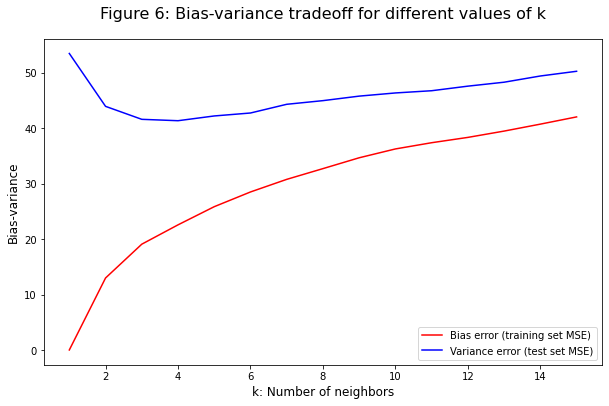

In [68]:
# Plot bias and variance tradeoff based on the results above

fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(mse_train_avg.keys(), mse_train_avg.values(), c='r', label='Bias error (training set MSE)')
plt.plot(mse_test_avg.keys(), mse_test_avg.values(), c='b', label='Variance error (test set MSE)')
plt.xlabel('k: Number of neighbors', fontsize=12)
plt.ylabel('Bias-variance', fontsize=12)
plt.title('Figure 7: Bias-variance tradeoff for different values of k', fontsize=16, pad=20)
plt.legend()

print()
plt.show()

As a final experiment, we compare the "large model" with the "small model" (see linear regression section for exact features) and see if fewer features makes the model better. We use the "optimal" k value above. This result is very interesting. The small model, with only 5 features, performs much better than the one with all 13 features (Table 5, Figure 7). Maybe it's not so surprising, as rather than weighting features using coefficients, the K-nn model must partition the features space into discrete clusters, and fewer features create more meaningful and stable clusters.

In [72]:
# Select the most inclusive feature sets

X = housing_df.drop(['median_house_val', 'crime_per_cap_2', 'ind_land_share_2', 'employ_centre_dist_2', 
                     'low_status_share_2'], axis='columns')

Y = housing_df['median_house_val']

mse_large_model = []
mse_small_model = []

# Train and test each model 30 times

for i in range(30):
    
    # Generate the training-test splits
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

    x2_train = x_train[['crime_per_cap', 'nitric_oxides', 'avg_no_rooms', 'pupil_teacher_ratio', 'low_status_share']]
    x2_test = x_test[['crime_per_cap', 'nitric_oxides', 'avg_no_rooms', 'pupil_teacher_ratio', 'low_status_share']]
    
    # Fit the different models 
    large_model = KNeighborsRegressor(n_neighbors=4).fit(x_train, y_train)
    small_model = KNeighborsRegressor(n_neighbors=4).fit(x2_train, y_train)     
    
    # Make predictions using each model
    y1_pred = large_model.predict(x_test)
    y2_pred = small_model.predict(x2_test)
    
    mse_large_model.append(mean_squared_error(y_test, y1_pred, squared=True))
    mse_small_model.append(mean_squared_error(y_test, y2_pred, squared=True))
                          
    mse_large_avg = round(sum(mse_large_model) / len(mse_large_model), 3)
    mse_small_avg = round(sum(mse_small_model) / len(mse_small_model), 3)                 

print()
print('Table 5: MSE for different K-nn models')
print()
print('Large model avg MSE:', mse_large_avg)
print('Small model avg MSE:', mse_small_avg)


Table 5: MSE for different K-nn models

Large model avg MSE: 39.514
Small model avg MSE: 18.962


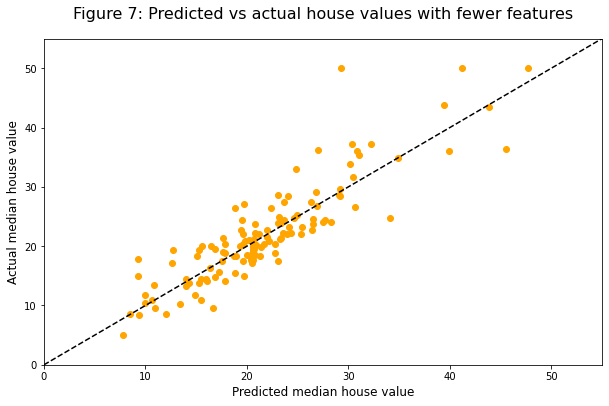

In [73]:
# Plot predicted vs actual values

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(y2_pred, y_test, color='orange')
plt.xlabel('Predicted median house value', fontsize=12)
plt.ylabel('Actual median house value', fontsize=12)
plt.plot([0, 55], [0, 55], ls='--', color='black')
plt.title('Figure 7: Predicted vs actual house values with fewer features', fontsize=16, pad=20)
plt.xlim(0, 55)
plt.ylim(0, 55)

print()
plt.show()

## Part 4: Neural network

### 4a) Introduction to neural networks

Neural networks is a machine learning model somewhat inspired by how the brain works. The model consists of multiple layers, each consisting of a number of "neurons". There is one input layer, one output layer and one or more hidden layers. The data in the input layer is passed to the first hidden layer, where weights are assigned to the input data to produce the output. The exact process is determined by the choice of activation function. The output of this layer is then passed on to the next hidden layer, where the process of assigning weights is repeated. Finally the output is passed to the output layer, which is then a function of all previous layers. 

### 4b) Set up a first neural network

We start by training a neural network using all 13 variables, and 2 hidden layers (the first one with 5 neurons and the second one with 3 neurons). We get an MSE of ~27 which is somewhat worse than the linear regression (Table 6).

In [75]:
# Train neural network and evaluate prediction quality

nn_regression = MLPRegressor(hidden_layer_sizes=(5, 3), max_iter=4000).fit(x_train, y_train)
y_pred = nn_regression.predict(x_test)

model_fit = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred, squared=True), 3)
bias = round(sum(y_pred) / sum(y_test) - 1, 3)
mape = round(np.mean(np.abs((y_test - y_pred) / y_test)), 3)

print()
print('Table 6: Performance metrics of neural network')
print()
print('MSE:', mse)
print('R^2:', model_fit)
print('Bias:', bias)
print('MAPE', mape)


Table 6: Performance metrics of neural network

MSE: 27.398
R^2: 0.609
Bias: 0.015
MAPE 0.201


### 4c) Trying with normalized data

We then train the same neural net, but this time we normalize the training and test data first. Now the model performs significantly better, with an MSE of ~19 (see Table 7).

In [76]:
# Normalize training and test sets 

norm_train = Normalizer().fit(x_train)
norm_train.transform(x_train)
norm_test = Normalizer().fit(x_test)
norm_test.transform(x_test)

# Fit model with normalized data and make prediction

nn_regression = MLPRegressor(hidden_layer_sizes=(5, 3), max_iter=4000).fit(x_train, y_train)
y_pred = nn_regression.predict(x_test)

model_fit = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred, squared=True), 3)
bias = round(sum(y_pred) / sum(y_test) - 1, 3)
mape = round(np.mean(np.abs((y_test - y_pred) / y_test)), 3)

print()
print('Table 7: Performance metrics of neural network, normalized data')
print()
print('MSE:', mse)
print('R^2:', model_fit)
print('Bias:', bias)
print('MAPE', mape)


Table 7: Performance metrics of neural network, normalized data

MSE: 18.598
R^2: 0.735
Bias: -0.013
MAPE 0.148


### 4d) Visualize the network

Now we try to visualize what is going on in the neural network through an illustration that shows the different layers and the connections between the neurons. In this illustration, the width of the line indicates the weight of that neuron on the end result. For example, it's not surprising that crime rate per capita (the first neuron in the input layer) has a significant impact on the house values in this model. That industrial land share (2) and pre-1940 units (7) don't have a great impact is maybe less surprising given what we saw in the pair-wise plots in the beginning.

Orange lines indicate positive weights while blue ones are negative. For example, we have average number of rooms (6). On the other hand we also have the Charles river dummy (4) which didn't seem to have a clear relationship with house values from the plots. One of the strong negative contributors is the low status population share (13) just like we've seen before.

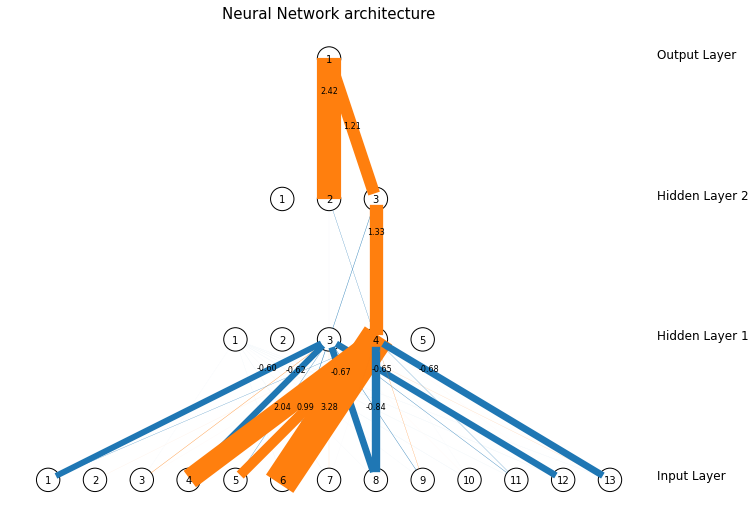

In [77]:
# Create visualization of neural network, with weights

network_structure = np.hstack(([x_train.shape[1]], np.asarray(nn_regression.hidden_layer_sizes), [1]))
network=VisNN.DrawNN(network_structure, nn_regression.coefs_)
network.draw()

### 4e) Trying to improving the model

We now try to improve the model by adding more layers and neurons per layer, which creates a more complex but potentially better model. We experiment with 2-3 hidden layers and varying number of neurons per layer to see which one gives the lowest MSE. It's not a major difference, but 3 layers with 25-15-10 neurons gives a slightly better result than 5-3 (Table 8)

In [99]:
X = housing_df.drop(['median_house_val', 'crime_per_cap_2', 'ind_land_share_2', 'employ_centre_dist_2', 
                     'low_status_share_2'], axis='columns')

Y = housing_df['median_house_val']

layers_neurons = [(15, 10, 5), (25, 15, 10), (50, 25, 10), 
                  (25, 25, 25, 25), (50, 50, 50, 50)]

mse_test_dict = {}
mse_train_dict = {}

for i in range(3):
    
    # Generate the training-test split and normalize
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
    norm_train = Normalizer().fit(x_train)
    norm_train.transform(x_train)
    norm_test = Normalizer().fit(x_test)
    norm_test.transform(x_test)
    
    # Loop through each setting, fit model and make predictions
    for s in range(len(layers_neurons)):
        
        nn_regression = MLPRegressor(hidden_layer_sizes=layers_neurons[s], max_iter=5000).fit(x_train, y_train)
        
        y_pred = nn_regression.predict(x_test)
        y_pred_train = nn_regression.predict(x_train)
        mse_test = mean_squared_error(y_test, y_pred, squared=True)
        mse_train = mean_squared_error(y_train, y_pred_train, squared=True)
        
        if i == 0:
            mse_test_dict[layers_neurons[s]] = [mse_test]
            mse_train_dict[layers_neurons[s]] = [mse_train]
        else:
            mse_test_dict[layers_neurons[s]].append(mse_test)
            mse_train_dict[layers_neurons[s]].append(mse_train)
            
mse_test_avg = {}
mse_train_avg = {}

for key, value in mse_test_dict.items():
    mse_test_avg[key] = sum(value) / len(value)
    
for key, value in mse_train_dict.items():
    mse_train_avg[key] = sum(value) / len(value)
    
print()
print('Table 8: Training and test MSE for different number of layers and neurons')
print()
print('Layers-neurons' + '\t\t' + 'Training MSE' + '\t' + 'Test MSE')
print()
for s in range(len(layers_neurons)):
    print(str(layers_neurons[s]).ljust(20) + '\t' + str(round(mse_train_avg[layers_neurons[s]], 3)).ljust(12) + '\t' 
          + str(round(mse_test_avg[layers_neurons[s]], 3)))


Table 8: Training and test MSE for different number of layers and neurons

Layers-neurons		Training MSE	Test MSE

(15, 10, 5)         	21.326      	24.883
(25, 15, 10)        	13.854      	16.936
(50, 25, 10)        	16.851      	18.69
(25, 25, 25, 25)    	16.952      	19.831
(50, 50, 50, 50)    	23.596      	26.014


Below we use these optimal settings to train and predict and plot the results using the normal plot (Figure 8).

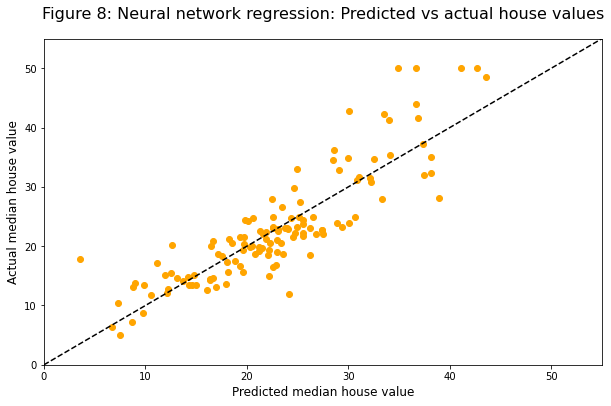

In [100]:
# Fitting and predicting using the chosen settings above

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
norm_train = Normalizer().fit(x_train)
norm_train.transform(x_train)
norm_test = Normalizer().fit(x_test)
norm_test.transform(x_test)

nn_regression = MLPRegressor(hidden_layer_sizes=(25, 15, 10), max_iter=5000).fit(x_train, y_train)
y_pred = nn_regression.predict(x_test)

model_fit = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred, squared=True), 3)
bias = round(sum(y_pred) / sum(y_test) - 1, 3)
mape = round(np.mean(np.abs((y_test - y_pred) / y_test)), 3)

# Plot predicted vs actual values

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(y_pred, y_test, color='orange')
plt.xlabel('Predicted median house value', fontsize=12)
plt.ylabel('Actual median house value', fontsize=12)
plt.plot([0, 55], [0, 55], ls='--', color='black')
plt.title('Figure 8: Neural network regression: Predicted vs actual house values', fontsize=16, pad=20)
plt.xlim(0, 55)
plt.ylim(0, 55)

print()
plt.show()

## Part 5: Conclusion

In this project we have used three different regression models for predicting median house prices in Boston suburbs: linear regression, K nearest neighbors and a neural network. 

The best model, when evaluating using MSE as the main metric, was a relatively complex neural network (MSE ~16). However, the performance wasn't dramatically better than a much simpler model like the linear regression (MSE ~18) and a K nearest neighbor model with few features. For this relatively simple problem, I would tend favor the linear regression due to it's simplicity and interpretability of parameters. Being able to understand how different factors impact house prices is as interesting as the prediction in this case.